# **Modelling Replication code**
This notebook replicates the main results presented in the paper, from training the model to analysing conservation scores.

In [776]:
from importlib import reload
import re
import random
random.seed(1337)
import os
import pickle
from decimal import Decimal
import collections

import numpy as np
np.random.seed(1337)
import pandas as pd
pd.options.mode.chained_assignment = None 
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Ridge

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import plotnine

# Dont use GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import model
import utils
import utils_data

In [2]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

#### Matplotlib config

In [2]:
import matplotlib_config

In [179]:
reload(matplotlib_config)
matplotlib_config.paper_config()

In [4]:
fig_dims = matplotlib_config.get_figsize(frac=1/3)

#### Utility functions

In [617]:
outputval_names = {"doudna": "rl_mean", "andreev":"log_load", "pcr3":"log_load", "eichhorn":"log_load",
                  "ptr":"ptr", "wilhelm":"ptr"}

# Function to compute correlations
def compute_corrs(df, model, one_hot_fn, key, extra_encoding_fn=[]):
    generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, 
                                                shuffle=False)
    predict = model.predict_generator(generator, verbose=0)
    return {"corr":(stats.pearsonr(predict.reshape(-1), df[outputval_names[key]]), 
                               stats.spearmanr(predict.reshape(-1), df[outputval_names[key]])),
            "pred":predict}

# Function to compute all test metrics
def compute_all_test_metrics(data_dict, model, min_len=None, extra_encoding_fn=[],
                             noTG = False,
                            postproc_mean=5.58621521, postproc_sd=1.34657403):
    result_dict = {}
    one_hot_fn = utils_data.OneHotEncoder("utr", min_len=min_len)
    # Test sets
    data_df = data_dict["mpra"]
    if noTG:
        data_df = data_df[~(data_df.utr.str[0:2] == "TG")]
    for key in ['egfp_unmod_1', 'mcherry_1', 'mcherry_2', 'egfp_unmod_2', 'human']:
        df = data_df[(data_df.library == key) & (data_df.set == "test")]
        generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, shuffle=False)
        predict = model.predict_generator(generator, verbose=0)
        if key == "egfp_unmod_1":
            result_dict[key] = (utils.rSquared(predict.reshape(-1), df["rl"]), utils.pearson_r(predict.reshape(-1), df["rl"])[0])
        else:
            result_dict[key] = utils.pearson_r(predict.reshape(-1), df["rl"])[0]
    varlen_df = data_dict["varlen_mpra"]
    for key in ['random', 'human']:
        df = varlen_df[(varlen_df.library == key) & (varlen_df.set == "test")]
        generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, shuffle=False)
        predict = model.predict_generator(generator, verbose=0)
        if key == "random":
            result_dict[key] = (utils.rSquared(predict.reshape(-1), df["rl"]), utils.pearson_r(predict.reshape(-1), df["rl"])[0])
        if key == "human":
            result_dict["human_varlen"] = utils.pearson_r(predict.reshape(-1), df["rl"])[0]
    # SNV
    df = data_dict["snv"]
    one_hot_fn_mother = utils_data.OneHotEncoder("mother", min_len=min_len)
    gen_wt = utils_data.DataSequence(df, encoding_functions=[one_hot_fn_mother] + extra_encoding_fn, shuffle=False)
    predict_wt = model.predict_generator(gen_wt, verbose=0)
    gen_snv = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, shuffle=False)
    predict_snv = model.predict_generator(gen_snv, verbose=0)
    if min_len is not None:
        predict_wt = predict_wt * postproc_sd + postproc_mean
        predict_snv = predict_snv * postproc_sd + postproc_mean
    log_pred_diff = np.log2(predict_snv/predict_wt)
    result_dict["snv"] = utils.pearson_r(log_pred_diff.reshape(-1), df["log_obs_diff"])[0]
    # Endogenous data
    for key in ["doudna", "andreev", "pcr3", "eichhorn", "ptr", "wilhelm"]:
        result_dict[key] = compute_corrs(data_dict[key], model, one_hot_fn, key, extra_encoding_fn=extra_encoding_fn)["corr"]
    return result_dict

# Function to compute metrics on endogenous data split by sequence length
def compute_split_metrics(data_dict, model, min_len=None, splits=[0, 100], extra_encoding_fn=[]):
    splits2 = splits[1:] + [1000000]
    result_dict = {str(split):{} for split in splits2[:-1]}
    result_dict["long"] = {}
    one_hot_fn = utils_data.OneHotEncoder("utr", min_len=min_len)
    for key in ["doudna", "andreev", "pcr3", "eichhorn", "ptr", "wilhelm"]:
        print("Analysing set: " + key)
        df = data_dict[key]
        for i in range(len(splits)):
            print("Analysing split from: " + str(splits[i]) + " to: " + str(splits2[i]))
            subset = df[(df.utr.str.len() > splits[i]) & (df.utr.str.len() <= splits2[i])]
            model_result = compute_corrs(subset, model, one_hot_fn, key, extra_encoding_fn=extra_encoding_fn)
            total_corr = model_result["corr"]
            pred = model_result["pred"]
            if i == len(splits) - 1:
                result_key = "long"
            else:
                result_key = str(splits2[i])
            result_dict[result_key][key] = {"corr":(total_corr[0][0], total_corr[1][0]),
                                           "pred":pred.reshape(-1),
                                           "obs":np.array(subset[outputval_names[key]]).reshape(-1)}
    return result_dict

# **Reading in the data**
Reading in the data pickle to run model training and/or evaluations

In [6]:
with open("../Data/data_dict.pkl", 'rb') as handle:
    data_dict = pickle.load(handle)

In [7]:
for key in data_dict:
    print(key)
    print(len(data_dict[key]))

mpra
980244
snv
1584
ptr
11575
wilhelm
5293
andreev
8003
pcr3
7672
eichhorn
8956
doudna
25831
varlen_mpra
102214


# **Training**
#### **(Skip if not making new model)**
This code shows how to train a framepool model from scratch

### Prepare training data

In [8]:
# length 50 mpra data
one_hot = utils_data.OneHotEncoder("utr")
mpra_data = data_dict["mpra"]
train_data_50 = mpra_data[(mpra_data.set == "train") & (mpra_data.library == "egfp_unmod_1")]
val_data = mpra_data[(mpra_data.set == "val") & (mpra_data.library == "egfp_unmod_1")]
encoded_mpra_train_50 = one_hot(train_data_50)
encoded_mpra_val = one_hot(val_data)

In [9]:
# variable length (up to 100) mpra data
mpra_data_varlen = data_dict["varlen_mpra"]
train_data = mpra_data_varlen[(mpra_data_varlen.set == "train") & (mpra_data_varlen.library == "random")]
encoded_mpra_train = one_hot(train_data)

In [11]:
# combined length 50 and variable length mpra data
train_data_combined = pd.concat([train_data[["utr", "rl", "library"]], train_data_50[["utr", "rl", "library"]]])
one_hot_fn = utils_data.OneHotEncoder("utr")
library_fn = utils_data.LibraryEncoder("library", {"egfp_unmod_1":0, "random":1})
out_encoding_fn = utils_data.DataFrameExtractor("rl", method="direct")
generator_combined = utils_data.DataSequence(train_data_combined, encoding_functions=[one_hot_fn, library_fn], 
                                    output_encoding_fn=out_encoding_fn, shuffle=True)

In [613]:
# without TG start
train_data_noTG = train_data_combined[~(train_data_combined.utr.str[0:2] == "TG")]
generator_noTG = utils_data.DataSequence(train_data_noTG, encoding_functions=[one_hot_fn, library_fn], 
                                    output_encoding_fn=out_encoding_fn, shuffle=True)

### Train a Model

In [620]:
reload(model)
utr_model = model.create_frame_slice_model(kernel_size=[7,7,7],
                        only_max_pool=False,
                        padding="same",
                        skip_connections="residual",
                        use_scaling_regression=True, library_size=2)

In [621]:
utr_model.fit_generator(generator_noTG, epochs=6, verbose=2)

Epoch 1/6
 - 159s - loss: 1.2391
Epoch 2/6
 - 284s - loss: 0.6966
Epoch 3/6
 - 282s - loss: 0.5559
Epoch 4/6
 - 282s - loss: 0.4806
Epoch 5/6
 - 283s - loss: 0.4513
Epoch 6/6
 - 284s - loss: 0.4200


In [628]:
utr_model.save("../Models/utr_model_combined_residual_noTG.h5")

### Evaluate it

In [46]:
utr_model_combined = load_model("..Models/Framepool_combined_residual_noTG.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

In [623]:
metrics = compute_all_test_metrics(data_dict, utr_model, extra_encoding_fn=[library_fn], noTG = True)

In [625]:
# pickle and save
with open("../Data/Metrics/metrics_frameslice_combined_noTG_dict.pkl", 'wb') as handle:
    pickle.dump(metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [626]:
with open("../Data/Metrics/metrics_frameslice_50_dict.pkl", 'rb') as handle:
    metrics_frameslice_50 = pickle.load(handle)
with open("../Data/Metrics/metrics_frameslice_100_dict.pkl", 'rb') as handle:
    metrics_frameslice_100 = pickle.load(handle)
with open("../Data/Metrics/metrics_frameslice_combined_dict.pkl", 'rb') as handle:
    metrics_frameslice_combined = pickle.load(handle)
with open("../Data/Metrics/metrics_frameslice_combined_noTG_dict.pkl", 'rb') as handle:
    metrics_frameslice_combined_noTG = pickle.load(handle)

In [627]:
for key in metrics_frameslice_100:
    print(key)
    print(metrics_frameslice_50[key])
    print(metrics_frameslice_100[key])
    print(metrics_frameslice_combined[key])
    print(metrics_frameslice_combined_noTG[key])

egfp_unmod_1
(0.9221064552942099, 0.9286913985005334)
(0.6238430947475788, 0.8626600121588603)
(0.9021292130831058, 0.9097982804043929)
(0.9176483663963254, 0.9234777685505821)
mcherry_1
0.6937217350567138
0.6557430404941327
0.6901184146770003
0.6983342416428424
mcherry_2
0.7625899974346826
0.7168778661688588
0.7495499047058781
0.7667770474909021
egfp_unmod_2
0.8502690102010035
0.8066638829680413
0.8314158699899794
0.8469290748854641
human
0.7779039427378039
0.7043140526130449
0.7515240412710117
0.7791964628818739
random
(-0.02819618345471775, 0.8109036397203787)
(0.79706930893472, 0.814719212159738)
(0.8315714881284952, 0.8348638498491876)
(0.7982508671235763, 0.8111453721672645)
human_varlen
0.7594276408239143
0.7807088113039873
0.79846334514603
0.7606855349993633
snv
0.5317956093905337
0.5247975465973355
0.5369803198493659
0.5136090571166904
doudna
((0.12579558122090928, 1.350383713736952e-91), SpearmanrResult(correlation=0.13118200770847457, pvalue=1.65365573710095e-99))
((0.156308

# **Validations**


## **Import all models**
We import all the models we need to run the validations

In [638]:
# Load models
utr_model_50 = load_model("../Models/utr_model_50.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer}) # Framepool50
utr_model = load_model("../Models/utr_model_100_residual.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer}) # Framepool100
library_fn = utils_data.LibraryEncoder("library", {"egfp_unmod_1":0, "random":1})
utr_model_combined = load_model("../Models/utr_model_combined_residual.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer}) # FramepoolCombined
utr_model_combined_noTG = load_model("../Models/utr_model_combined_residual_noTG.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})
paper_model_orig = load_model("../Models/main_MRL_model.hdf5") # Optimus50
paper_model = load_model("../Models/retrained_main_MRL_model.hdf5") 
paper_model2 = load_model("../Models/Varying_length_25to100_model.hdf5") # Optimus100
modelname_dict = {"Optimus50": paper_model_orig, "Framepool50": utr_model_50,
                  "Optimus100": paper_model2, "Framepool100": utr_model, "FramepoolCombined": utr_model_combined}

## **Validation on MPRA data**
We plot the performance of our models and Optimus models on MPRA data

In [635]:
# Code to run a prediction on MPRA data
def predict_on_MPRA(model, data_dict, varlen = False, library = "egfp_unmod_1", min_len = None,
                    extra_encoding_fn=[], postproc_mean=5.58621521, postproc_sd=1.34657403):
    one_hot_fn = utils_data.OneHotEncoder("utr", min_len=min_len)
    if varlen:
        data_df = data_dict["varlen_mpra"].copy()
    else:
        data_df = data_dict["mpra"].copy()
    df = data_df[(data_df.library == library) & (data_df.set == "test")]
    generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn] + extra_encoding_fn, shuffle=False)
    predict = model.predict_generator(generator, verbose=0)
    if min_len is not None:
        predict = predict * postproc_sd + postproc_mean
    df["pred"] = predict.reshape(-1)
    df = df.rename(columns={"pred": "Predicted MRL", "rl": "Observed MRL"})
    return df

In [803]:
# build dataframe
def build_mpra_prediction():
    concat_df = pd.DataFrame(columns=['Predicted MRL', 'Observed MRL', 'model', 'data', 'R'])
    for modelname in ["Optimus50", "Framepool50", "Optimus100", "Framepool100", "FramepoolCombined"]:
        predmodel = modelname_dict[modelname]
        min_len = None
        if modelname == "Optimus50":
            min_len = 50
        if modelname == "Optimus100":
            min_len = 100
        extra_encoding_function = []
        if modelname == "FramepoolCombined":
            extra_encoding_function = [library_fn] 
        for data in [("Fixed length (50 nt) MPRA", "egfp_unmod_1", False), ("Variable length (25-100 nt) MPRA", "random", True)]:
            varlen = data[2]
            dataname = data[0]
            library = data[1]
            pred_df = predict_on_MPRA(predmodel, data_dict, varlen = varlen, library = library, min_len = min_len,
                                     extra_encoding_fn = extra_encoding_function)
            pred_df = pred_df[["Predicted MRL", "Observed MRL"]]
            #print((modelname, dataname))
            pred_df["model"] = modelname
            pred_df["data"] = dataname
            pred_df["R"] = round(stats.pearsonr(pred_df["Predicted MRL"], pred_df["Observed MRL"])[0], 3)
            concat_df = pd.concat([concat_df, pred_df])
    return concat_df

mpra_pred_df = build_mpra_prediction()

In [804]:
mpra_pred_df[["model", "data", "R"]].drop_duplicates()

,model,data,R
0,Optimus50,Fixed length (50 nt) MPRA,0.966
1,Optimus50,Variable length (25-100 nt) MPRA,0.743
0,Framepool50,Fixed length (50 nt) MPRA,0.964
1,Framepool50,Variable length (25-100 nt) MPRA,0.901
0,Optimus100,Fixed length (50 nt) MPRA,0.938
1,Optimus100,Variable length (25-100 nt) MPRA,0.915
0,Framepool100,Fixed length (50 nt) MPRA,0.929
1,Framepool100,Variable length (25-100 nt) MPRA,0.903
0,FramepoolCombined,Fixed length (50 nt) MPRA,0.954
1,FramepoolCombined,Variable length (25-100 nt) MPRA,0.914


/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


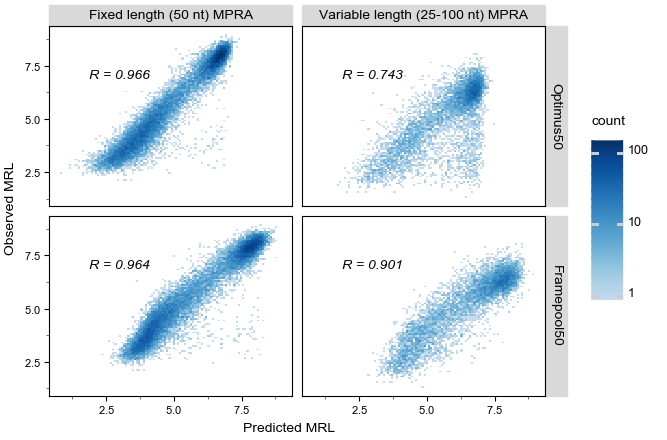

<ggplot: (8752736144697)>

In [849]:
# Build a subset
mpra_pred_df_sub = mpra_pred_df[mpra_pred_df.model.isin(["Optimus50","Framepool50"])]

# Fix labels
plotlabel_dict = {"A": "Optimus50", "B": "Framepool50", "C": "Fixed length (50 nt) MPRA", "D": "Variable length (25-100 nt) MPRA"}
inv_plotlabel_dict = {v: k for k, v in plotlabel_dict.items()}
mpra_pred_df_sub["model_factor"] = mpra_pred_df_sub["model"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_df_sub["data_factor"] = mpra_pred_df_sub["data"].apply(lambda x: inv_plotlabel_dict[x])
mpra_pred_R_df_sub = mpra_pred_df_sub[["model_factor", "data_factor", "R"]].drop_duplicates()
mpra_pred_R_df_sub["R"] = mpra_pred_R_df_sub["R"].apply(lambda x: "R = " + str(x))
labeller = plotnine.facets.labelling.as_labeller(plotlabel_dict)

# Plot
p = (plotnine.ggplot(mpra_pred_df_sub, plotnine.aes('Predicted MRL', 'Observed MRL'))
 #+ plotnine.geom_point(alpha = 0.05, shape = ".", color = "darkblue")
 + plotnine.geom_bin2d(binwidth = 0.08)
 + plotnine.scale_fill_continuous(ListedColormap(cm.get_cmap('Blues', 512)(np.linspace(0.25, 1, 384))), trans="log10")
 + plotnine.facet_grid('model_factor ~ data_factor', labeller = labeller)
 + plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 3, y = 7, label = "R"), fontstyle = "italic")
 + plotnine.theme_matplotlib())
p

In [796]:
p.save("../Graphics/" + "Fig2" + ".svg", width=7.0, height=7.0*0.66)

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7.0 x 4.326 in image.
  from_inches(height, units), units), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Graphics/test2.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3

In [442]:
# Plotting code adapted from the Sample et al
def plot_mpra_test(e_test, xlims=(1.5,8), ylims=(1.5,8),
                   fig_dims=(2.5,2),
                   r_squared_pos=(6, 2), r_squared_size=8,
                   color = (0.3, 0.45, 0.69),
                   put_xlabel=True, put_ylabel=True,
                  dot_size=2, font_size=10, alpha=0.2,
                  file=""):
    r_squared = utils.pearson_r(e_test["pred"], e_test["rl"])[0]
    
    #atg = e_test[e_test['utr'].apply(lambda x: 'ATG' in x)]
    #n_atg = e_test[e_test['utr'].apply(lambda x: 'ATG' not in x)]

    #c1 = (0.3, 0.45, 0.69)
    #c2 = 'r'
    g = sns.JointGrid(x='rl', y="pred", data=e_test, space=0, xlim=(2,10), ylim=(2,10), height=4)
    g.plot_joint(plt.scatter,s=dot_size, color=color, linewidth=0.2, alpha=alpha, edgecolor='white', 
                 rasterized=True)
    #fig, ax = plt.subplots(figsize=fig_dims)
    #ax.scatter(e_test["rl"], e_test["pred"], s=dot_size, color=color, alpha=alpha, rasterized=True)
    xlabel = "      "
    ylabel = "      "
    if put_xlabel:
        xlabel = 'Observed MRL'
    if put_ylabel:
        ylabel = 'Predicted MRL'
    g.set_axis_labels(xlabel, ylabel, **{'size':font_size})
    fig = g.fig
    ax = fig.gca()
    ax.set_yticks(np.arange(1,9.01, 1));
    ax.set_yticklabels(range(1,10),size=font_size);
    ax.set_xticks(np.arange(1,9.01, 1));
    ax.set_xticklabels(range(1,10),size=font_size);
    ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlim(xlims[0],xlims[1])
    ax.text(x=r_squared_pos[0], y=r_squared_pos[1], style="italic", s='R = ' + str(round(np.sqrt(r_squared), 3)), 
            size=r_squared_size)
    fig.set_size_inches(fig_dims)
    fig.savefig("../Graphics/" + file + ".svg")

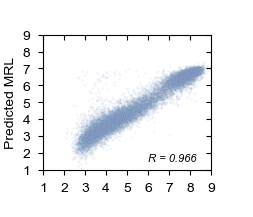

In [443]:
# Optimus 50 on MPRA 50
e_test = predict_on_MPRA(paper_model_orig, data_dict, min_len=50)
plot_mpra_test(e_test,file="mpratest_Optimus50on50",xlims=(1,9), ylims=(1,9), alpha=0.1,
              r_squared_pos=(6, 1.5), put_xlabel=False)

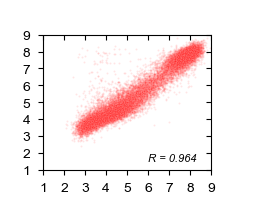

In [451]:
# Frameslice 50 on MPRA 50
e_test = predict_on_MPRA(utr_model_50, data_dict)
plot_mpra_test(e_test,file="mpratest_Frameslice50on50",xlims=(1,9), ylims=(1,9), alpha=0.1,
              r_squared_pos=(6, 1.5), color="r", put_xlabel=False, put_ylabel=False)

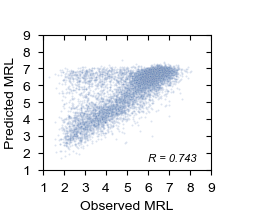

In [455]:
# Optimus50 on MPRA 100
e_test = predict_on_MPRA(paper_model_orig, data_dict, varlen=True, library="random", min_len=50)
plot_mpra_test(e_test,file="mpratest_Optimus50on100", xlims=(1,9), ylims=(1,9), r_squared_pos=(6, 1.5))

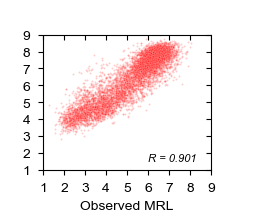

In [456]:
# Frameslice50 on MPRA 100
e_test = predict_on_MPRA(utr_model_50, data_dict, varlen=True, library="random")
plot_mpra_test(e_test,file="mpratest_Frameslice50on100", xlims=(1,9), ylims=(1,9), r_squared_pos=(6, 1.5),
              color='r', put_ylabel=False)

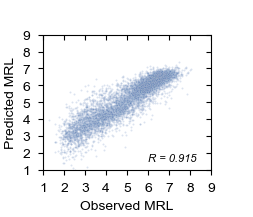

In [447]:
# Optimus 100 on MPRA 100
varlen_mean = train_data["rl"].mean()
varlen_sd = train_data["rl"].std()
e_test = predict_on_MPRA(paper_model2, data_dict, varlen=True, library="random", min_len=100,
                        postproc_mean=varlen_mean,postproc_sd=varlen_sd)
plot_mpra_test(e_test,file="mpratest_Optimus100on100", xlims=(1,9), ylims=(1,9), r_squared_pos=(6, 1.5))

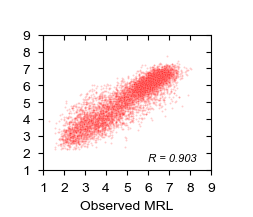

In [450]:
# Frameslice 100 on MPRA 100
e_test = predict_on_MPRA(utr_model, data_dict, varlen=True, library="random")
plot_mpra_test(e_test,file="mpratest_Frameslice100on100", xlims=(1,9), ylims=(1,9), r_squared_pos=(6, 1.5),
              color="r", put_ylabel=False)

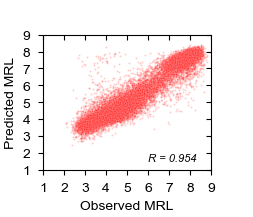

In [448]:
# Frameslice combined on MPRA 50
e_test = predict_on_MPRA(utr_model_combined, data_dict, extra_encoding_fn=[library_fn])
plot_mpra_test(e_test,file="mpratest_FramesliceCombinedon50", xlims=(1,9), ylims=(1,9), r_squared_pos=(6, 1.5),
              color="r")

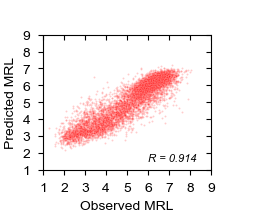

In [449]:
# Frameslice combined on MPRA 100
e_test = predict_on_MPRA(utr_model_combined, data_dict, varlen=True, library="random", extra_encoding_fn=[library_fn])
plot_mpra_test(e_test,file="mpratest_FramesliceCombinedon100", xlims=(1,9), ylims=(1,9), r_squared_pos=(6, 1.5),
              color="r")

## **Validation on endogenous data**
We plot the performance of our models and Optimus models on endogenous data, split by sequence length

#### Compute split metrics

In [ ]:
metrics_split_optimus_50 = compute_split_metrics(data_dict, paper_model, min_len=50, splits=[0, 50])
metrics_split_frameslice_50 = compute_split_metrics(data_dict, utr_model_50, splits=[0, 50])

In [ ]:
metrics_split_optimus_100 = compute_split_metrics(data_dict, paper_model2, min_len=100)
metrics_split_frameslice_100 = compute_split_metrics(data_dict, utr_model)

In [ ]:
metrics_split_frameslice_combined = compute_split_metrics(
    data_dict, utr_model_combined, extra_encoding_fn=[library_fn])

In [60]:
# Save computed metrics
with open("../Data/Metrics/metrics_split_optimus_50_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_optimus_50, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("../Data/Metrics/metrics_split_frameslice_50_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_frameslice_50, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("../Data/Metrics/metrics_split_optimus_100_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_optimus_100, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("../Data/Metrics/metrics_split_frameslice_100_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_frameslice_100, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("../Data/Metrics/metrics_split_frameslice_combined_dict.pkl", 'wb') as handle:
    pickle.dump(metrics_split_frameslice_combined, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Prepare metric data

In [798]:
# Load metrics
with open("../Data/Metrics/metrics_split_frameslice_50_dict.pkl", 'rb') as handle:
    metrics_split_frameslice_50 = pickle.load(handle)
with open("../Data/Metrics/metrics_split_optimus_50_dict.pkl", 'rb') as handle:
    metrics_split_optimus_50 = pickle.load(handle)
with open("../Data/Metrics/metrics_split_frameslice_100_dict.pkl", 'rb') as handle:
    metrics_split_frameslice_100 = pickle.load(handle)
with open("../Data/Metrics/metrics_split_optimus_100_dict.pkl", 'rb') as handle:
    metrics_split_optimus_100 = pickle.load(handle)
with open("../Data/Metrics/metrics_split_frameslice_combined_dict.pkl", 'rb') as handle:
    metrics_split_frameslice_combined = pickle.load(handle)

In [851]:
# build dataframe with data types, correlations and bootstrapping significance results
# Facet grid categories:
splittype_1 = "Human 5'UTR shorter than longest training sequence"
splittype_2 = "Human 5'UTR longer than longest training sequence"
traintype_1 = "Trained on 50 nt MPRA"
traintype_2 = "Trained on 25-100 nt MPRA"


metricname_dict = {"Optimus50": metrics_split_optimus_50, "Framepool50": metrics_split_frameslice_50,
                  "Optimus100": metrics_split_optimus_100, "Framepool100": metrics_split_frameslice_100}

def corr_wrapper(pred, obs, corr = "pearson"):
    if corr == "pearson":
        return stats.pearsonr(pred, obs)[0]
    else:
        return stats.spearmanr(pred, obs)[0]

# bootstrapping
def do_bootstrap(df, n_samples=100, std_factor=stats.norm.ppf(0.9998), corr = "pearson"):
    our_bootstrap = []
    paper_bootstrap = []
    for i in range(n_samples):
        sub = df.sample(frac=1, replace=True)
        our_bootstrap.append(corr_wrapper(sub["pred_our"], sub["obs_our"], corr = corr))
        paper_bootstrap.append(corr_wrapper(sub["pred_paper"], sub["obs_paper"], corr = corr))
    diff = [x - y for x,y in zip(our_bootstrap, paper_bootstrap)]
    mean_diff = np.mean(diff)
    error_diff = np.std(diff)*std_factor
    sig = "Significant"
    if mean_diff < 0 and mean_diff + error_diff > 0:
        sig = "Not " + sig
    elif mean_diff > 0 and mean_diff - error_diff < 0:
        sig = "Not " + sig
    return sig

def build_mpra_prediction():
    datalabels_dict = {"doudna":"Floor", "andreev":"Andreev", "pcr3":"Xiao", "eichhorn":"Eichhorn", "ptr":"Eraslan", "wilhelm":"Wilhelm"}
    datatype_dict = {"doudna":"Trip-seq", "andreev":"Ribo-seq", "pcr3":"Ribo-seq", "eichhorn":"Ribo-seq", "ptr":"PTR", "wilhelm":"PTR"}
    splittype_dict = {"50": splittype1, 
                      "100": splittype1,
                     "long": splittype2}
    traindatatype_dict = {"50": traintype_1, 
                          "100": traintype_2}
    rows_list = []
    for comparison in [("Optimus50", "Framepool50", "50"), ("Optimus100", "Framepool100", "100")]:
        for split in [comparison[2], "long"]:
            for data in ["doudna", "andreev", "pcr3", "eichhorn", "ptr", "wilhelm"]:
                bootstrap_df = pd.DataFrame({"pred_paper": metricname_dict[comparison[0]][split][data]["pred"],
                        "obs_paper":metricname_dict[comparison[0]][split][data]["obs"],
                        "pred_our":metricname_dict[comparison[1]][split][data]["pred"],
                        "obs_our":metricname_dict[comparison[1]][split][data]["obs"]})
                r_optimus = stats.pearsonr(bootstrap_df["pred_paper"], bootstrap_df["obs_paper"])[0]
                r_framepool = stats.pearsonr(bootstrap_df["pred_our"], bootstrap_df["obs_our"])[0]
                rho_optimus = stats.spearmanr(bootstrap_df["pred_paper"], bootstrap_df["obs_paper"])[0]
                rho_framepool = stats.spearmanr(bootstrap_df["pred_our"], bootstrap_df["obs_our"])[0]
                sig = do_bootstrap(bootstrap_df, corr = "pearson")
                sig_rho = do_bootstrap(bootstrap_df, corr = "spearman")
                row = {"Pearson's R of Optimus predictions with observed values": r_optimus,
                      "Pearson's R of Framepool predictions with observed values": r_framepool,
                       "Spearman's rho of Optimus predictions with observed values": rho_optimus,
                      "Spearman's rho of Framepool predictions with observed values": rho_framepool,
                       "significant_diff_Pearson": sig,
                       "significant_diff_Spearman": sig_rho,
                      "data": datalabels_dict[data],
                      "data_type": datatype_dict[data],
                      "split_type": splittype_dict[split],
                      "train_data_type": traindatatype_dict[comparison[2]]}
                rows_list.append(row)
    return pd.DataFrame(rows_list)

split_metric_df = build_mpra_prediction()

In [867]:
# save
split_metric_df.to_csv("../Data/Metrics/split_metric_df.csv")

#### Plot split metrics

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


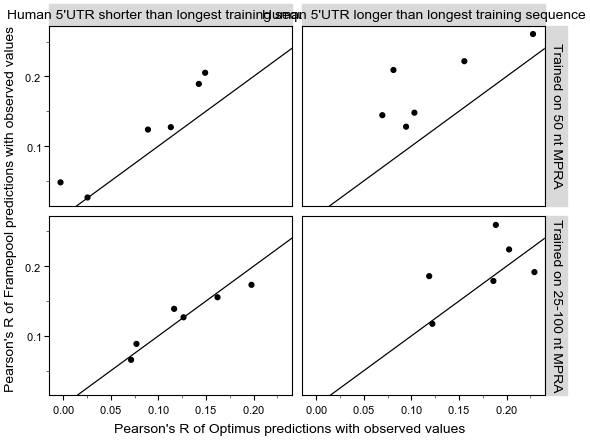

<ggplot: (-9223363284146236679)>

In [874]:
# Make categoricals for values used to order facet grid
split_metric_df['split_type_cat'] = pd.Categorical(split_metric_df['split_type'], categories=[splittype_1,splittype_2])
split_metric_df['train_type_cat'] = pd.Categorical(split_metric_df['train_data_type'], categories=[traintype_1,traintype_2])

# 
p = (plotnine.ggplot(split_metric_df, plotnine.aes("Pearson's R of Optimus predictions with observed values", 
                                                    "Pearson's R of Framepool predictions with observed values"))
 + plotnine.geom_point()
 + plotnine.facet_grid('train_type_cat ~ split_type_cat')
 + plotnine.geom_abline()
 #+ plotnine.geom_text(size = 10, data = mpra_pred_R_df_sub, mapping = plotnine.aes(x = 3, y = 7, label = "R"), fontstyle = "italic")
 + plotnine.theme_matplotlib())
p

In [ ]:
plotlabel_dict = {"A": "Trained on 50 nt MPRA", "B": "Trained on 25-100 nt MPRA", 
                  "C": "Human 5'UTR shorter than longest training sequence", 
                  "D": "Human 5'UTR longer than longest training sequence"}



In [457]:
corr_type_dict = {"pearson":0, "spearman":1}

def plot_metrics(metrics, metrics_paper, split="long", model="slice100", corr_type="spearman",
                fig_dims=(3.75, 3.0), font_size=10, font_size_lbl=8, n_samples=100, dot_size=11,
                suppress_lbls=False, std_factor=3, suppress_legend=True):
    ordered_keys = ["doudna", "andreev", "pcr3", "eichhorn", "ptr", "wilhelm"]
    #labels = ["Floor (TripSeq)", "Andreev (RiboSeq)", "Xiao (RiboSeq)", "Eichhorn (RiboSeq)",
    #         "Eraslan (PTR)", "Wilhelm (PTR)"]
    labels = ["Floor", "Andreev", "Xiao", "Eichhorn", "Eraslan", "Wilhelm"]
    markers = ["o", "^", "v"]
    y = [metrics[split][key]["corr"][corr_type_dict[corr_type]] 
         for key in ordered_keys]
    x = [metrics_paper[split][key]["corr"][corr_type_dict[corr_type]]
         for key in ordered_keys]
    color = []
    bar_our = []
    bar_paper = []
    error_bar = []
    for idx,key in enumerate(ordered_keys):
        new_df = pd.DataFrame({"pred_paper":metrics_paper[split][key]["pred"],
                              "obs_paper":metrics_paper[split][key]["obs"],
                              "pred":metrics[split][key]["pred"],
                                "obs":metrics[split][key]["obs"]})
        our_bootstrap = []
        paper_bootstrap = []
        for i in range(n_samples):
            sub = new_df.sample(frac=1, replace=True)
            if corr_type == "pearson":
                our_bootstrap.append(stats.pearsonr(sub["pred"], sub["obs"])[0])
                paper_bootstrap.append(stats.pearsonr(sub["pred_paper"], sub["obs_paper"])[0])
            else:
                our_bootstrap.append(stats.spearmanr(sub["pred"], sub["obs"])[0])
                paper_bootstrap.append(stats.spearmanr(sub["pred_paper"], sub["obs_paper"])[0])
        
        diff = [x - y for x,y in zip(our_bootstrap, paper_bootstrap)]
        mean_diff = np.mean(diff)
        #print(mean_diff)
        error_diff = np.std(diff)*std_factor
        #print(error_diff)
        #error_bar.append(np.std(diff)*2)
        if mean_diff < 0 and mean_diff + error_diff > 0:
            color.append("grey")
        elif mean_diff > 0 and mean_diff - error_diff < 0:
            color.append("grey")
        else:
            color.append("black")
        
        #bar_our.append(np.std(our_bootstrap)*2)
        #bar_paper.append(np.std(paper_bootstrap)*2)
    fig, ax = plt.subplots(figsize=fig_dims)
    ax.set_xlim(0, 0.3)
    ax.set_ylim(0, 0.3)

    line = np.linspace(*ax.get_xlim())
    ax.plot(line, line, color="grey", linestyle="--")
    
    if not suppress_lbls:
        ax.set_xlabel("Spearman's rho with \n Optimus Predictions",fontsize=font_size)
        ax.set_ylabel("Spearman's rho with \n Frameslice Predictions",fontsize=font_size)
    ax.tick_params(labelsize=font_size)

    subset = [(0,1), (1,4), (4,6)]
    for i,idx in enumerate(subset):
        ax.scatter(x[idx[0]:idx[1]],y[idx[0]:idx[1]], c=color[idx[0]:idx[1]], s=dot_size, marker=markers[i])
    #ax.scatter(x,y, c=color, s=dot_size, marker=markers)
    #ax.errorbar(x, y, xerr=bar_paper, yerr=bar_our, capsize=8, ecolor = "k", fmt=' ')
    
    if not suppress_legend:
        symbols = ([#Line2D([0], [0], marker=None, linestyle="--", color='black', label='y=x',
                          #markerfacecolor='black', markersize=3),
                    Line2D([0], [0], marker='o', color='w', label='Trip-Seq',
                          markerfacecolor='black', markersize=3),
                    Line2D([0], [0], marker='^', color='w', label='Ribo-Seq',
                          markerfacecolor='black', markersize=3),
                    Line2D([0], [0], marker='v', color='w', label='PTR',
                          markerfacecolor='black', markersize=3),
                    Line2D([0], [0], marker='o', color='w', label='Not Significant',
                          markerfacecolor='grey', markersize=3)])
        ax.legend(handles=symbols, frameon=False)
    
    for i, txt in enumerate(labels):
        ax.annotate(txt, (x[i]+0.002, y[i]+0.002), fontsize=font_size_lbl)
        # Diag error bars
        # ax.plot(np.linspace(x[i] - error_bar[i], x[i] + error_bar[i]), 
        #         np.flip(np.linspace(y[i] - error_bar[i], y[i] + error_bar[i])), 
        #         color="black")
    
    sns.despine(fig)
    
    fig.savefig("../Graphics/metrics_plot_" + model + "_" + split + ".svg")

In [409]:
fig_dims = (2.5, 2.0)
font_size = 10
font_size_lbl = 8

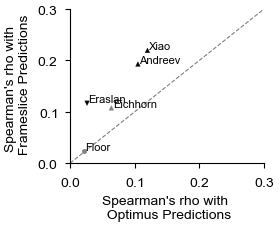

In [461]:
plot_metrics(metrics_split_frameslice_50, metrics_split_optimus_50, split="50", model="slice50", corr_type="spearman",
                fig_dims=fig_dims, font_size=font_size, font_size_lbl=font_size_lbl,
            n_samples=100)

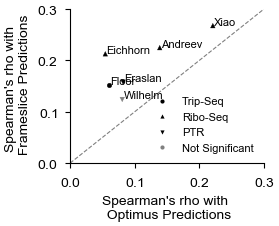

In [460]:
plot_metrics(metrics_split_frameslice_50, metrics_split_optimus_50, split="long", model="slice50", corr_type="spearman",
                fig_dims=fig_dims, font_size=font_size, font_size_lbl=font_size_lbl,
            n_samples=100, suppress_legend=False)

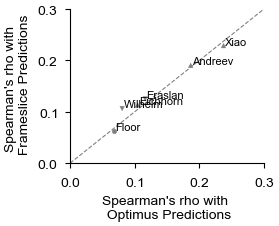

In [459]:
plot_metrics(metrics_split_frameslice_100, metrics_split_optimus_100, split="100", corr_type="spearman",
                fig_dims=fig_dims, font_size=font_size, font_size_lbl=font_size_lbl,
            n_samples = 100)

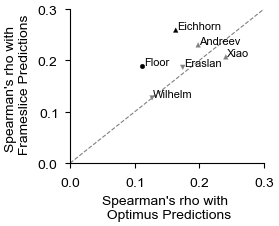

In [458]:
plot_metrics(metrics_split_frameslice_100, metrics_split_optimus_100, split="long", corr_type="spearman",
                fig_dims=fig_dims, font_size=font_size, font_size_lbl=font_size_lbl,
            n_samples = 100)

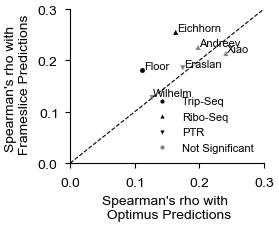

In [395]:
# combined model
plot_metrics(metrics_split_frameslice_combined, metrics_split_optimus_100, split="long", model="slice_combined", corr_type="spearman",
                fig_dims=fig_dims, font_size=font_size, font_size_lbl=font_size_lbl,
            n_samples = 100, suppress_legend=False)

## **TIS Strength validation**
We prepare and run our in-silico experiment to evaluate our model's understanding of uTIS motifs

#### Impact of AUG context on predicted SNV effect

In [17]:
noderer_df_aug = pd.read_csv("../Data/TIS/tis_efficiencies_aug.tsv", sep='\t')
noderer_df_aug = noderer_df_aug.rename(index=str, columns={"sequence":"TIS_Sequence", "efficiency":"TIS_Efficiency"})
noderer_df_nonaug = pd.read_csv("../Data/TIS/tis_efficiencies_nonaug.tsv", sep='\t')

# Recode U to T
noderer_df_aug["TIS_Sequence"] = noderer_df_aug["TIS_Sequence"].str.replace("U", "T")
noderer_df_nonaug["TIS_Sequence"] = noderer_df_nonaug["TIS_Sequence"].str.replace("U", "T")

# Prepare injection
noderer_df_aug["TIS_Sequence_AGG"] = [seq[:7] + "G" + seq[8:] for seq in noderer_df_aug["TIS_Sequence"]]
bad_end = noderer_df_aug["TIS_Sequence"].str.endswith("AT")
double_trouble = noderer_df_aug["TIS_Sequence_AGG"].str.contains("ATG")
noderer_df_aug_sub = noderer_df_aug[(~bad_end) & (~double_trouble)]
noderer_df_aug = noderer_df_aug_sub

In [55]:
extra_encoding_fn = [library_fn]
model_to_apply = utr_model_combined

one_hot_fn_inactive = utils_data.OneHotEncoder("wt")
one_hot_fn_active = utils_data.OneHotEncoder("snv")
samples = 100
diffs = []
for i in range(samples):
    prefix = ''.join(random.choices(["C","T","G"], k=9))
    suffix = ''.join(random.choices(["C","T","G"], k=9))
    noderer_df_aug["snv"] = [prefix + seq + suffix for seq in
                                            noderer_df_aug["TIS_Sequence"]]
    noderer_df_aug["wt"] = [prefix + seq + suffix for seq in
                                        noderer_df_aug["TIS_Sequence_AGG"]]
    gen_wt = utils_data.DataSequence(noderer_df_aug, encoding_functions=[one_hot_fn_inactive] + extra_encoding_fn, 
                                     shuffle=False)
    predict_wt_only = model_to_apply.predict_generator(gen_wt, verbose=0)
    gen_snv = utils_data.DataSequence(noderer_df_aug, encoding_functions=[one_hot_fn_active] + extra_encoding_fn, 
                                      shuffle=False)
    predict_snv_only = model_to_apply.predict_generator(gen_snv, verbose=0)
    log_pred_diff_only = np.log2(predict_snv_only/predict_wt_only)
    diffs.append(log_pred_diff_only)
diffs = sum(diffs)/len(diffs)
noderer_df_aug["Predicted log2 Fold Change"] = diffs.reshape(-1)
print(stats.pearsonr(noderer_df_aug["TIS_Efficiency"], diffs.reshape(-1)))
print(stats.spearmanr(noderer_df_aug["TIS_Efficiency"], diffs.reshape(-1)))

(-0.7946999837983739, 0.0)
SpearmanrResult(correlation=-0.7648457052769003, pvalue=0.0)


In [260]:
with open("../Data/tis_aug_diffs.pkl", 'wb') as handle:
    pickle.dump(diffs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [261]:
with open("../Data/tis_aug_diffs.pkl", 'rb') as handle:
    diffs = pickle.load(handle)

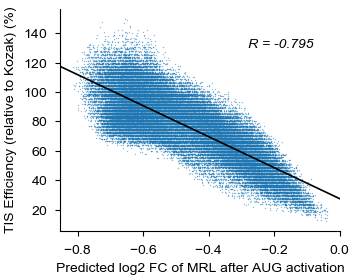

In [403]:
font_size = 10
fig_dims = (3.75, 3.0)

x = sns.regplot(x='Predicted log2 Fold Change', y="TIS_Efficiency", data=noderer_df_aug, ci=None, line_kws={"color":"black"}, 
                scatter_kws={"s": 1, "alpha":0.5, "rasterized":True})
x.set_xlabel("Predicted log2 FC of MRL after AUG activation",fontsize=font_size)
x.set_ylabel("TIS Efficiency (relative to Kozak) (%)",fontsize=font_size)
x.text(x=-0.28, y=130, style="italic", s='R = ' + 
       str(round(stats.pearsonr(noderer_df_aug["TIS_Efficiency"], diffs.reshape(-1))[0], 3)), size=font_size)
x.tick_params(labelsize=font_size)
f = x.get_figure()
f.set_size_inches(fig_dims)
f.tight_layout()
sns.despine(f)
f.savefig("../Graphics/Tis_Aug_rasta.svg")

#### Nonaug starts and their context

In [24]:
atg_trouble = noderer_df_nonaug["TIS_Sequence"].str.contains("ATG")
noderer_df_nonaug = noderer_df_nonaug[~atg_trouble]

In [33]:
extra_encoding_fn = [library_fn]
model_to_apply = utr_model_combined

nonaug_dict = {key:noderer_df_nonaug[noderer_df_nonaug["TIS_Sequence"].str[-4:-1] == key] for key in
               set(noderer_df_nonaug["TIS_Sequence"].str[-4:-1])}
key_to_inactive = {'CTG':"CTT", 'ACG':"ACT", 'AAG':"AAC", 'GTG':"GTT", 
                   'ATA':"ATT", 'AGG':"AGT", 'ATT':"GTT", 'ATC':"GTC", 
                   'TTG':"TTT"}
metrics_nonaug = {}
one_hot_fn_inactive = utils_data.OneHotEncoder("wt")
one_hot_fn_active = utils_data.OneHotEncoder("snv")
samples = 100
for key in nonaug_dict.keys():
    nonaug_dict[key]["TIS_inactive"] = [seq[:-4] + key_to_inactive[key] + seq[-1] for seq in
                                        nonaug_dict[key]["TIS_Sequence"]]
    diff_list = []
    for i in range(samples):
        prefix = ''.join(random.choices(["C","T","G"], k=9))
        suffix = ''.join(random.choices(["C","T","G"], k=9))
        nonaug_dict[key]["snv"] = [prefix + seq + suffix for seq in
                                            nonaug_dict[key]["TIS_Sequence"]]
        nonaug_dict[key]["wt"] = [prefix + seq + suffix for seq in
                                        nonaug_dict[key]["TIS_inactive"]]
        gen_wt = utils_data.DataSequence(nonaug_dict[key], encoding_functions=[one_hot_fn_inactive] + extra_encoding_fn, 
                                         shuffle=False)
        predict_wt_nonaug = model_to_apply.predict_generator(gen_wt, verbose=0)
        gen_snv = utils_data.DataSequence(nonaug_dict[key], encoding_functions=[one_hot_fn_active] + extra_encoding_fn, 
                                          shuffle=False)
        predict_snv_nonaug = model_to_apply.predict_generator(gen_snv, verbose=0)
        log_pred_diff_nonaug = np.log2(predict_snv_nonaug/predict_wt_nonaug)
        diff_list.append(log_pred_diff_nonaug)
    diffs = sum(diff_list)/len(diff_list)    
    metrics_nonaug[key] = (stats.pearsonr(nonaug_dict[key]["TIS_Efficiency"], diffs.reshape(-1)),
                              stats.spearmanr(nonaug_dict[key]["TIS_Efficiency"], diffs.reshape(-1)))
    nonaug_dict[key]["Predicted log2 Fold Change"] = diffs

In [34]:
metrics_nonaug

{'ACG': ((-0.5208540149337733, 4.477573666051672e-70),
  SpearmanrResult(correlation=-0.4117255417033055, pvalue=7.174094470422214e-42)),
 'AAG': ((-0.0694760261690944, 0.028661985664739088),
  SpearmanrResult(correlation=-0.07312663209671151, pvalue=0.021257516075557283)),
 'TTG': ((-0.023506396640644286, 0.4595870883334633),
  SpearmanrResult(correlation=-0.14605388870351163, pvalue=3.853922584714896e-06)),
 'CTG': ((-0.4871139617820911, 3.0600212870794866e-60),
  SpearmanrResult(correlation=-0.4042290948132368, pvalue=2.7619407240386374e-40)),
 'ATA': ((0.06337329029664547, 0.045988739798082955),
  SpearmanrResult(correlation=0.0600073019944047, pvalue=0.05885007779188783)),
 'GTG': ((-0.5324825227951455, 4.421531873413513e-69),
  SpearmanrResult(correlation=-0.31525232211838683, pvalue=7.371783124546117e-23)),
 'ATC': ((0.0009714565996250884, 0.9756216725572221),
  SpearmanrResult(correlation=0.008568375709274975, pvalue=0.7875183787428974)),
 'AGG': ((-0.15533829061571225, 8.82211

In [384]:
with open("../Data/nonaug_dict.pkl", 'wb') as handle:
    pickle.dump(nonaug_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
with open("../Data/nonaug_dict.pkl", 'rb') as handle:
    nonaug_dict = pickle.load(handle)

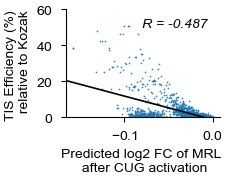

In [404]:
font_size = 10
fig_dims = (2.5, 2.0)

noderer_df_cug = nonaug_dict["CTG"]
x = sns.regplot(x='Predicted log2 Fold Change', y="TIS_Efficiency", data=noderer_df_cug, ci=None, line_kws={"color":"black"}, 
                scatter_kws={"s": 1.5, "alpha":0.9, "rasterized":True})
#x.set_title("Predicted uAUG SNV Impact on CDK2NA varies with context", fontsize=13)
x.set_xlabel("Predicted log2 FC of MRL \n after CUG activation",fontsize=font_size)
x.set_ylabel("TIS Efficiency (%) \n relative to Kozak",fontsize=font_size)
x.set_ylim(0,60)
x.text(x=-0.08, y=50, style="italic", s='R = ' + 
       str(round(stats.pearsonr(noderer_df_cug["TIS_Efficiency"], noderer_df_cug["Predicted log2 Fold Change"])[0], 3)), 
       size=font_size)
x.tick_params(labelsize=font_size)
f = x.get_figure()
f.set_size_inches(fig_dims)
f.tight_layout()
sns.despine(f)
f.savefig("../Graphics/Tis_Cug_rasta.svg")

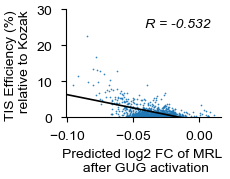

In [405]:
font_size = 10
fig_dims = (2.5, 2.0)

noderer_df_gug = nonaug_dict["GTG"]
x = sns.regplot(x='Predicted log2 Fold Change', y="TIS_Efficiency", data=noderer_df_gug, ci=None, line_kws={"color":"black"}, 
                scatter_kws={"s": 1.5, "alpha":0.9, "rasterized":True})
#x.set_title("Predicted uAUG SNV Impact on CDK2NA varies with context", fontsize=13)
x.set_xlabel("Predicted log2 FC of MRL \n after GUG activation",fontsize=font_size)
x.set_ylabel("TIS Efficiency (%) \n relative to Kozak",fontsize=font_size)
x.set_ylim(0,30)
x.text(x=-0.041, y=25, style="italic", s='R = ' + 
       str(round(stats.pearsonr(noderer_df_gug["TIS_Efficiency"], noderer_df_gug["Predicted log2 Fold Change"])[0], 3)), 
       size=font_size)
x.tick_params(labelsize=font_size)
f = x.get_figure()
f.set_size_inches(fig_dims)
f.tight_layout()
sns.despine(f)
f.savefig("../Graphics/Tis_Gug_rasta.svg")

## **Nonaug Sequences (Behaviour on 50nt set w/o AUG)**

An analysis to check how the model behaves on non-aug sequences

#### Structure

In [595]:
one_hot_fn = utils_data.OneHotEncoder("utr")
library_fn = utils_data.LibraryEncoder("library", {"egfp_unmod_1":0, "random":1})
data_noaug = mpra_data[(mpra_data.library == "egfp_unmod_1") & (mpra_data.set != "test")
                          & (~mpra_data.utr.str.contains("ATG"))]
generator_noaug = utils_data.DataSequence(data_noaug, encoding_functions=[one_hot_fn, library_fn], 
                                    output_encoding_fn=None, shuffle=False)
data_noaug["pred"] = utr_model_combined.predict_generator(generator_noaug).reshape(-1)
data_noaug_noTG = data_noaug[~(data_noaug["utr"].str[0:2] == "TG")]

In [607]:
print(stats.pearsonr(data_noaug["pred"], data_noaug["rl"]))

(0.6244264796490494, 0.0)


In [598]:
print(stats.pearsonr(data_noaug["pred"], -data_noaug["utr_energy"]))
print(stats.spearmanr(data_noaug["pred"], -data_noaug["utr_energy"]))

(-0.34569959913646864, 0.0)
SpearmanrResult(correlation=-0.38942085700797147, pvalue=0.0)


#### GC Content

In [599]:
print(stats.pearsonr(data_noaug["pred"], (data_noaug["utr"].str.count("G") + data_noaug["utr"].str.count("C"))/50))
print(stats.spearmanr(data_noaug["pred"], (data_noaug["utr"].str.count("G") + data_noaug["utr"].str.count("C"))/50))

(-0.5236313655690584, 0.0)
SpearmanrResult(correlation=-0.6182908032577178, pvalue=0.0)


#### Kozak sequence

In [605]:
data_noaug["kozak"] = data_noaug["utr"].str[-6:]
one_hot_kozak = utils_data.OneHotEncoder("kozak")
X = one_hot_kozak(data_noaug).reshape((len(data_noaug), 24))
y = np.array(data_noaug["pred"])
reg = LinearRegression().fit(X, y)
r2 = reg.score(X, y)
print("LinReg r2 : " + str(reg.score(X, y)))
reg = Ridge().fit(X, y)
print("Ridge r2 : " + str(reg.score(X, y)))

LinReg r2 : 0.15968792595404746
Ridge r2 : 0.15973801648879915


In [601]:
r2_adjusted = utils.adjust_r2(r2, X.shape[0], X.shape[1])
print(r2_adjusted)

0.22862655766465856


In [587]:
for idx in range(6):
    print("Pos: " + str(idx - 6))
    print("A: " + str(reg.coef_[0 + idx*4]))
    print("C: " + str(reg.coef_[1 + idx*4]))
    print("G: " + str(reg.coef_[2 + idx*4]))
    print("T: " + str(reg.coef_[3 + idx*4]))

Pos: -6
A: 0.04121955237332102
C: -0.07356027494544327
G: 0.007399498568564108
T: 0.024941224000093968
Pos: -5
A: 0.007604155571840407
C: -0.03273682637528169
G: -0.0394832739687865
T: 0.06461594476707097
Pos: -4
A: 0.05937809131318027
C: -0.013196113103436246
G: -0.04178055925970393
T: -0.004401418942868569
Pos: -3
A: 0.11810353734944945
C: -0.0608052462583951
G: 0.09861034609381161
T: -0.15590863718131645
Pos: -2
A: 0.04616225626456959
C: 0.009201051385165143
G: -0.10685821405827228
T: 0.051494906408202784
Pos: -1
A: 0.05648181806729322
C: -0.005107575439702407
G: -0.03994896116630581
T: -0.011425281447469184


In [606]:
print(data_noaug[data_noaug["kozak"].str[-3] == "A"]["pred"].mean())
print(data_noaug[data_noaug["kozak"].str[-3] == "C"]["pred"].mean())
print(data_noaug[data_noaug["kozak"].str[-3] == "G"]["pred"].mean())
print(data_noaug[data_noaug["kozak"].str[-3] == "T"]["pred"].mean())

7.635938
7.4565187
7.60665
7.36476


In [568]:
r2_by_pos = []
for idx in range(1,12):
    print(-idx)
    data_noaug["kozak_pos"] = data_noaug["utr"].str[-idx]
    one_hot_pos = utils_data.OneHotEncoder("kozak_pos")
    X = one_hot_pos(data_noaug).reshape(len(data_noaug), 4)
    y = np.array(data_noaug["pred"])
    reg = Ridge().fit(X, y)
    print(reg.score(X, y))
    r2_by_pos.append(reg.score(X, y))

-1
0.012188875804470145
-2
0.02414924758904602
-3
0.08449375707108842
-4
0.016089828631844938
-5
0.01028407362951278
-6
0.01299960331535499
-7
0.0069745245756122065
-8
0.008652044125863956
-9
0.006335419061400227
-10
0.007645239697720352
-11
0.008511548426793691


In [570]:
np.sum(r2_by_pos[:6])

0.1602053860413173

## **Conservation: PhyloP score validation**
We predict the effect of all possible snv in loss of of function genes and compare it to the phyloP conservation scores

In [121]:
from kipoiseq.extractors import FastaStringExtractor
from kipoiseq.extractors import MultiSampleVCF, VariantSeqExtractor
from kipoiseq.dataloaders.sequence import BedDataset
from kipoiseq.utils import to_scalar

import pybedtools
from pybedtools import BedTool, Interval

Write predictions for all possible snv in all 5utr in lof genes

In [160]:
# Function to create an in-silico SNP array
nuc_dict = {'a':[1.0,0.0,0.0,0.0],'c':[0.0,1.0,0.0,0.0],'g':[0.0,0.0,1.0,0.0], 'u':[0.0,0.0,0.0,1.0], 
            't':[0.0,0.0,0.0,1.0], 'n':[0.0,0.0,0.0,0.0], 'x':[1/4,1/4,1/4,1/4]}
permutation_array = np.array([[1.0,0.0,0.0,0.0], [0.0,1.0,0.0,0.0], [0.0,0.0,1.0,0.0], [0.0,0.0,0.0,1.0]])

def create_permutations(seq, min_len=None):
    n = len(seq) * 4
    seq = seq.lower()
    one_hot = np.array([nuc_dict[x] for x in seq])
    one_hot_permuted = np.repeat(one_hot[np.newaxis,:,:], n, axis=0)
    for i in range(len(seq)):
        one_hot_permuted[i*4:(i*4)+4,i] = permutation_array
    if min_len is not None:
        diff = min_len - len(seq)
        if diff > 0:
            padding = np.zeros((n+1,diff, 4))
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
            one_hot_permuted = np.concatenate([padding, one_hot_permuted], axis=1)
        if diff < 0:
            one_hot_permuted = one_hot_permuted[np.abs(diff)*4:,np.abs(diff):,:]
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,np.abs(diff):,:], one_hot_permuted], axis=0)
        if diff == 0:
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
    else:
        one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
    return one_hot_permuted

def create_snv_array(seq, model, min_len=None,
                     postproc_mean=5.58621521, postproc_sd=1.34657403,
                    add_frame=False, add_library=False, suppress_postproc=False):
    if add_frame:
        frame = utils.build_frame(len(seq), (len(seq)*4) + 1)
        predictions = model.predict([create_permutations(seq, min_len=min_len), frame])
    elif add_library:
        indicator = np.zeros(((len(seq)*4) + 1,2))
        indicator[:,1] = 1
        predictions = model.predict([create_permutations(seq, min_len=min_len), indicator])
    else:
        predictions = model.predict(create_permutations(seq, min_len=min_len))
    if min_len is not None and not suppress_postproc:
        predictions =  predictions * postproc_sd + postproc_mean
    delta = np.log2(predictions[1:]/predictions[0])
    if min_len is not None and len(seq) > min_len:
        delta = delta.reshape((min_len, 4))
        diff = len(seq) - min_len
        padding = np.zeros((diff, 4))
        delta = np.concatenate([padding, delta], axis=0)
    else:
        delta = delta.reshape((len(seq), 4))
    return delta

def write_arrays(df, model, path, min_len=None, add_frame=False, add_library=False,
                 suppress_postproc=False,
                check_and_skip=False):
    for seq_id, seq in zip(df["EnsemblTranscriptID"], df["utr"]):
        if len(seq) == 1:
            continue
        if check_and_skip and os.path.exists(path + "SNPdelta_" + seq_id + ".npy"):
            continue
        delta = create_snv_array(seq, model, min_len=min_len, add_frame=add_frame, add_library=add_library,
                                suppress_postproc=suppress_postproc)
        np.save(path + "SNPdelta_" + seq_id + ".npy", np.transpose(delta))

def read_array(pos_df, transcript_id, base_path = "../Data/All_Variants/",
              snv_path="Genecode_v19_new/", cons_path="phylop/"):
    array = np.load(base_path + snv_path + "SNPdelta_" + transcript_id + ".npy")
    pos = pos_df[pos_df.EnsemblTranscriptID == transcript_id].iloc[0]
    indices = np.concatenate([np.arange(x[0],x[1]) for x in eval(pos["pos"])])
    atg_dist = np.flip(np.arange(len(indices))) + 1
    conservation = np.load(base_path + cons_path + "phyloP_" + transcript_id + ".npy")
    if pos["strand"] == "-":
        indices = np.flip(indices)
        conservation = np.flip(conservation)
    return pd.DataFrame({"EnsemblTranscriptID":pos["EnsemblTranscriptID"], 
                         "chr":pos["chr"], "strand":pos["strand"], "pos_ensembl":indices+1,
                         "dist_to_atg":atg_dist,
                         "conservation":conservation,
                        "A":array[0,:],"C":array[1,:],"G":array[2,:],"T":array[3,:]})

def read_all_arrays(pos_df, snv_path="Genecode_v19_frameslice_100/"):
    data = []
    i = 0
    for transcript_id in pos_df["EnsemblTranscriptID"]:
        arr = read_array(pos_df, transcript_id, snv_path=snv_path)
        data.append(arr)
        if i % 1000 == 0:
            print(i)
        i += 1
    arr = pd.concat(data)
    return arr

In [159]:
seq_df = pd.read_csv("../Data/gencodev19_5utr_seq.csv")
pos_df = pd.read_csv("../Data/gencodev19_5utr_pos.csv")
# remove length 1 utrs, as they can not yield sensible predictions and only mess with numpy
seq_df = seq_df[seq_df["utr"].str.len() > 1]
pos_df = pos_df[pos_df["EnsemblTranscriptID"].
                isin(seq_df[seq_df["utr"].str.len() > 1]["EnsemblTranscriptID"])]
# reduce to lof intolerant genes
# Lof intolerant: "oe_lof_upper" < 0.35
lof_df = pd.read_csv("../Data/GTF/gencodev19_5utr_lof.bed", sep="\t",
                     names=["chr", "start", "stop", "EnsemblTranscriptID", "?", "strand"])
pos_df = pos_df[pos_df["EnsemblTranscriptID"].isin(lof_df["EnsemblTranscriptID"])]
seq_df = seq_df[seq_df["EnsemblTranscriptID"].isin(lof_df["EnsemblTranscriptID"])]

In [127]:
write_arrays(seq_df, utr_model, "../Data/All_Variants/Genecode_v19_frameslice_100/")

In [91]:
write_arrays(seq_df, utr_model_combined, "../Data/All_Variants/Genecode_v19_frameslice_combined/", add_library=True)

In [161]:
# write for utr model with truncation
write_arrays(seq_df, utr_model, "../Data/All_Variants/Genecode_v19_frameslice_100_truncated/", min_len=100, suppress_postproc=True)

In [316]:
seq_df_100 = seq_df["EnsemblTranscriptID"][seq_df["utr"].str.len() <= 100]
seq_df_long = seq_df["EnsemblTranscriptID"][seq_df["utr"].str.len() > 100]

In [389]:
# write arrays for paper model
write_arrays(seq_df[seq_df["EnsemblTranscriptID"].isin(seq_df_100)], paper_model2, 
                    "../Data/All_Variants/Genecode_v19_paper/", min_len=100)

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in log2


In [498]:
# write arrays for paper model with truncation
write_arrays(seq_df, paper_model2, 
                    "../Data/All_Variants/Genecode_v19_paper_truncated/", min_len=100)

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in log2


Compare predicted snv effects to conservation score

In [162]:
arr = read_all_arrays(pos_df)

0
1000
2000
3000
4000
5000
6000
7000
8000


In [163]:
arr_truncated = read_all_arrays(pos_df, snv_path="Genecode_v19_frameslice_100_truncated/")

0
1000
2000
3000
4000
5000
6000
7000
8000


In [164]:
arr_paper_truncated = read_all_arrays(pos_df, snv_path="Genecode_v19_paper_truncated/")

0
1000
2000
3000
4000
5000
6000
7000
8000


In [173]:
arr["avg_effect"] = np.sum(np.abs(np.array(arr[["A","C","G","T"]])), axis = 1)/3
arr_truncated["avg_effect"] = np.sum(np.abs(np.array(arr_truncated[["A","C","G","T"]])), axis = 1)/3
arr_paper_truncated["avg_effect"] = np.sum(np.abs(np.array(arr_paper_truncated[["A","C","G","T"]])), axis = 1)/3
arr_far = arr[arr["dist_to_atg"] > 100]
arr_truncated = arr_truncated[arr_truncated["dist_to_atg"] <= 100]
arr_paper_truncated = arr_paper_truncated[arr_paper_truncated["dist_to_atg"] <= 100]

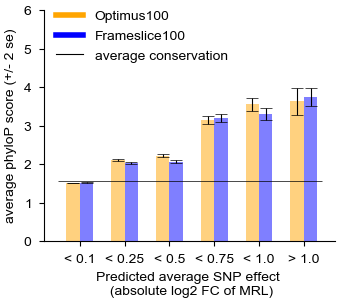

In [406]:
fig_dims = (3.75, 3.0)
font_size = 10
capsize = 4.5

w = 0.3
colors = ["orange", "blue"]

cuts = [0, 0.1, 0.25, 0.5, 0.75, 1.0]
cuts2 = cuts[1:] + [100]
scores_paper = []
scores = []
scores_long = []
sem_paper = []
sem = []
sem_long = []
counts_paper = []
counts = []
counts_long = []
for l,u in zip(cuts, cuts2):
    #paper
    scores_paper.append(arr_paper_truncated[(arr_paper_truncated["avg_effect"] < u) & 
                                            (arr_paper_truncated["avg_effect"] > l)]["conservation"].mean())
    sem_paper.append(arr_paper_truncated[(arr_paper_truncated["avg_effect"] < u) & 
                                         (arr_paper_truncated["avg_effect"] > l)]["conservation"].sem() * 2)
    counts_paper.append(len(arr_paper_truncated[(arr_paper_truncated["avg_effect"] < u) & 
                                                (arr_paper_truncated["avg_effect"] > l)]))
    # ours
    scores.append(arr_truncated[(arr_truncated["avg_effect"] < u) & (arr_truncated["avg_effect"] > l)]["conservation"].mean())
    sem.append(arr_truncated[(arr_truncated["avg_effect"] < u) & (arr_truncated["avg_effect"] > l)]["conservation"].sem() * 2)
    counts.append(len(arr_truncated[(arr_truncated["avg_effect"] < u) & (arr_truncated["avg_effect"] > l)]))
    # ours long
    scores_long.append(arr_far[(arr_far["avg_effect"] < u) & (arr_far["avg_effect"] > l)]["conservation"].mean())
    sem_long.append(arr_far[(arr_far["avg_effect"] < u) & (arr_far["avg_effect"] > l)]["conservation"].sem() * 2)
    counts_long.append(len(arr_far[(arr_far["avg_effect"] < u) & (arr_far["avg_effect"] > l)]))
x_pos = np.arange(len(scores))
names = ["< " + str(x) for x in cuts2[:-1]] + ["> " + str(cuts[-1])]

# Build the plot
fig, ax = plt.subplots()
paper_pos = x_pos-(w/2)
ax.bar(paper_pos, scores_paper, width=w, align='center', alpha=0.5, ecolor='black', capsize=10,
       color=colors[0], label="Optimus")
(_, caps, _) = ax.errorbar(paper_pos, scores_paper, sem_paper, capsize=capsize, ecolor = "k", fmt=' ')
for cap in caps:
    cap.set_color('k')
    cap.set_markeredgewidth(0.5)
our_pos = x_pos + (w/2)  
ax.bar(our_pos, scores, width=w, align='center', alpha=0.5, ecolor='black', capsize=10,
       color=colors[1], label="Frame-slice")
(_, caps, _) = ax.errorbar(our_pos, scores, sem, capsize=capsize, ecolor = "k", fmt=' ')
for cap in caps:
    cap.set_color('k')
    cap.set_markeredgewidth(0.5)

    
# Labelling
ax.set_ylabel('average phyloP score (+/- 2 se)', fontsize=font_size)
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_xlabel("Predicted average SNP effect \n (absolute log2 FC of MRL)", fontsize=font_size)
ax.set_ylim((0,6))
ax.tick_params(labelsize=font_size)
#ax.hlines(y=2,xmin=-0.5, xmax=5.4, linewidth=0.5)
ax.hlines(y=np.mean(arr_truncated["conservation"]),xmin=-0.5, xmax=5.4, linewidth=0.5)

custom_lines = [Line2D([0], [0], color=colors[0], lw=4, label="Optimus100"),
                Line2D([0], [0], color=colors[1], lw=4, label="Frameslice100"),
                Line2D([0], [0], marker='_', color='black', label='average conservation',
                          markerfacecolor='black', markersize=3)]
ax.legend(loc=(0.02,0.75), handles=custom_lines, frameon=False, fontsize=font_size)

fig.set_size_inches(fig_dims)

sns.despine(fig)

fig.savefig("../Graphics/phylop_bar_comparePos.svg")

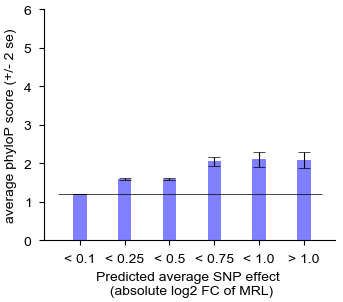

In [252]:
fig, ax = plt.subplots()

long_pos = x_pos
ax.bar(long_pos, scores_long, width=w, align='center', alpha=0.5, ecolor='black', capsize=10,
       color="blue", label="Frame-slice (>100 nt to TIS)")
(_, caps, _) = ax.errorbar(long_pos, scores_long, sem_long, capsize=capsize, ecolor = "k", fmt=' ')
for cap in caps:
    cap.set_color('k')
    cap.set_markeredgewidth(0.5)

    
# Labelling
ax.set_ylabel('average phyloP score (+/- 2 se)', fontsize=font_size)
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_xlabel("Predicted average SNP effect \n (absolute log2 FC of MRL)", fontsize=font_size)
ax.set_ylim((0,6))
ax.tick_params(labelsize=font_size)
#ax.legend(loc=(0.02,0.8), handletextpad=0.2, fontsize=font_size)
#ax.hlines(y=2,xmin=-0.5, xmax=5.4, linewidth=0.5)
ax.hlines(y=np.mean(arr_far["conservation"]),xmin=-0.5, xmax=5.4, linewidth=0.5)

fig.set_size_inches(fig_dims)

sns.despine(fig)

fig.savefig("../Graphics/phylop_bar_farPos.svg")

In [176]:
## Add counts in post
print(counts_paper)
print(counts)
print(counts_long)

[721903, 48870, 17081, 2647, 908, 247]
[719022, 46827, 21567, 2586, 1180, 477]
[1618941, 44841, 12511, 1487, 592, 320]
